**Poisson equation in 1D with Dirichlet boundary conditions**

Retyped by Theodoret Putra Agatho on 6 Aug. 2023

[Source](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/poisson.1d.dirichlet.html)

In [1]:
pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 5.5 MB/s eta 0:00:00


**Problem setup**

We will solve a Possion equation:

\begin{align}
        -\Delta u = \pi ^2 \text{sin} (\pi x), x \in [-1, 1],
    \end{align}

with the Dirichlet boundary conditions

\begin{align}
        u(-1) = 0, u(1) = 0.
    \end{align}

The exact solution is $u(x) = \text{sin} (\pi x)$.

**Implementation**

This description goes through the implementation of a solver for the above described Poisson equation step-by-step.

First, the DeepXDE and TensorFlow (`tf`) modules are imported:

In [5]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

We begin by defining a computational geometry. We can use a built-in class `Interval` as follows

In [3]:
geom = dde.geometry.Interval(-1, 1)

Next, we express the PDE residual of the Possion equation:

In [4]:
def pde(x, y):
  dy_xx = dde.grad.hessian(y, x)
  return -dy_xx - np.pi ** 2 * tf.sin(np.pi * x)

The first argument to `pde` is the network input, i.e., the $x$-coordinaate. The second argument is the network output, i.e., the solution $u(x)$, but here we use `y` as the name of the variable.

Next, we consider the Dirichlet boundary condition. A simple Python function, returning a boolean, is used to define the subdomain for the Dirichlet boundary condition (${-1,1}$). The function should return `True` for those points inside the subdomain and `False` for the points outside. In our case, the points $x$ of the Dirichlet boundary condition are $x=-1$ and $x=1$. (Note that because of rounding-off errors, it is often wise to use `dde.utils.isclose` to test whether two floating point values are equivalent.)

In [6]:
def boundary(x, _):
  return dde.utils.isclose(x[0], -1) or dde.utils.isclose(x[0], 1)

The argument `x` to `boundary` is the network input and is a $d$-dim vector, where $d$ is the dimension and $d=1$ in this case. To facilitate the implementation of `boundary`, a boolean `on_boundary` is used as the second argument. If the point `x` (the first argument) is on the entire boundary of the geometry (the left and right endpoints of the interval in this case), then `on_boundary` is `True`, otherwise, `on_boundary` is `False`. Thus, we can also define `boundary` in a simpler way:

In [7]:
def boundary(x, on_boundary):
  return on_boundary

Next, we define a function to return the value of $u(x)$ for the points $x$ on the boundary. In this case, it is $u(x) = 0$.

In [8]:
def func(x):
  return 0

If the function value is not a constant, we can also use NumPy to compute. For example, $sin(\pi x)$ is 0 on the boundary, and thus we can also use

In [9]:
def func(x):
  return np.sin(np.pi * x)

Then, the Dirichlet boundary condition is

In [10]:
bc = dde.icbc.DirichletBC(geom, func, boundary)

Now, we have specified the geometry, PDE residual, and Dirichlet boundary condition. We then define the PDE problem as

In [11]:
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

The number 16 is the number of training residual points sampled inside the domain, and the number 2 is the number of training points sampled on the boundary. The argument `solution=func` is the reference solution to compute the error of our solution, and can be ignored if we don't have a reference solution. We use 100 residual points for testing the PDE residual.

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e, 3 hidden layers) and width 50:

In [12]:
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

Now, we have the PDE problem and the network. We build a `Model` and choose the optimizer and learning rate:

In [13]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.077585 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.551454 s



We also compute the $L^2$ relative error as a metric during training. We can also use `callbacks` to save the model and the movie during training, which is optional.

In [15]:
checkpointer = dde.callbacks.ModelCheckpoint(
    "model/model.ckpt", verbose=1, save_better_only=True
)
# ImageMagick (https://immagemagick.org/) is required to generate the movie.
movie = dde.callbacks.MovieDumper(
    "model/movie", [-1], [1], period=100, save_spectrum=True, y_reference=func
)

We then train the model for 10000 iterations:

In [17]:
losshistory, train_state = model.train(
    iterations=10000, callbacks=[checkpointer, movie]
)

Training model...

Step      Train loss              Test loss               Test metric   
0         [4.36e+01, 4.33e-05]    [4.93e+01, 4.33e-05]    [9.97e-01]    
Epoch 1: train loss improved from inf to 4.36e+01, saving model to model/model.ckpt-1.ckpt ...

1000      [4.71e-04, 1.16e-07]    [6.27e-04, 1.16e-07]    [3.52e-04]    
Epoch 1000: train loss improved from 4.36e+01 to 4.71e-04, saving model to model/model.ckpt-1000.ckpt ...

2000      [1.29e-04, 7.51e-09]    [2.29e-04, 7.51e-09]    [1.37e-04]    
Epoch 2000: train loss improved from 4.71e-04 to 1.29e-04, saving model to model/model.ckpt-2000.ckpt ...

3000      [7.13e-05, 2.97e-06]    [1.04e-04, 2.97e-06]    [1.59e-03]    
Epoch 3000: train loss improved from 1.29e-04 to 7.43e-05, saving model to model/model.ckpt-3000.ckpt ...

4000      [3.56e-04, 4.76e-05]    [2.37e-04, 4.76e-05]    [6.25e-03]    
5000      [1.62e-05, 4.41e-07]    [3.77e-05, 4.41e-07]    [5.81e-04]    
Epoch 5000: train loss improved from 7.43e-05 to 1.67

Saving the movie of spectrum to model/movie_spectrum.txt, model/movie_spectrum.gif...



Best model at step 5000:
  train loss: 1.67e-05
  test loss: 3.81e-05
  test metric: [5.81e-04]

'train' took 36.577972 s



**Additional Visualisation**

Additional code to give visualisation of the results. Taken parts are from **Complete code** section.

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


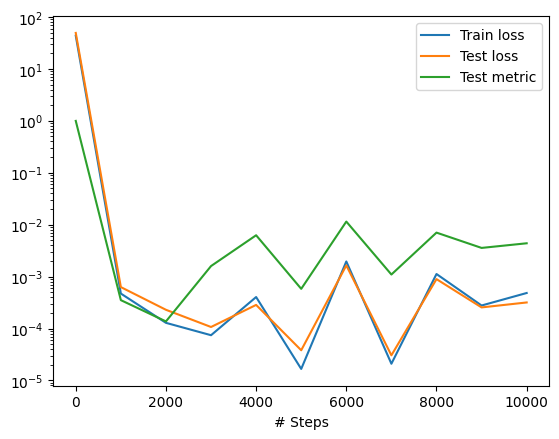

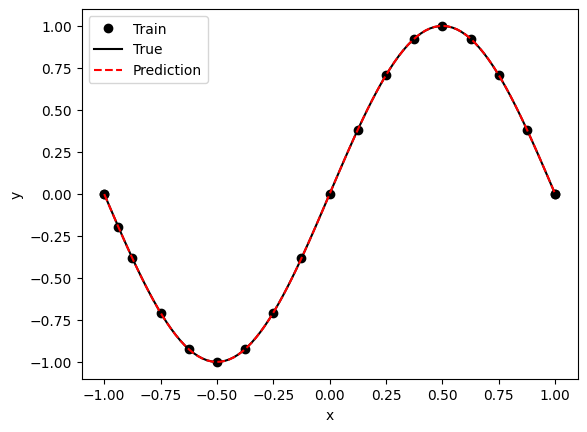

In [18]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [20]:
import matplotlib.pyplot as plt

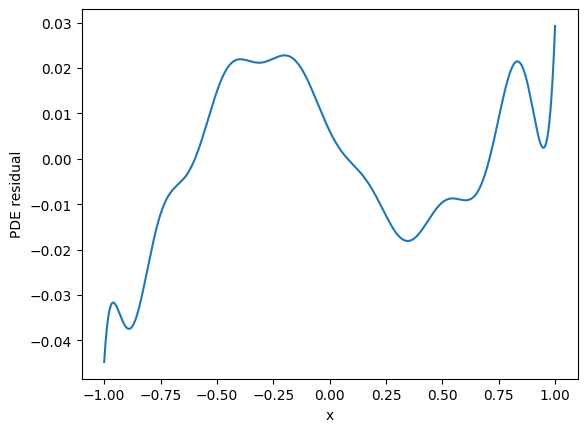

In [21]:
# Optional: Restore the saved model with the smallest training loss
# model.restore(f"model/model-{train_state.best_step}.ckpt", verbose=1)
# Plot PDE residual
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=pde)
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()